<a href="https://colab.research.google.com/github/ST10055763/PDAN-8412-ICE-1/blob/main/Getting_Started_with_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with PySpark

## Install Spark and Java

Spark requires Java to run because it is built on the JVM. We download and extract Apache Spark (V.3.5.0). The findspark library helps Python to locate Spark installation easily

In [ ]:
# Install OpenJDK11
!apt-get install openjdk-11-jdk-headless -qq > /dev/null  # Install OpenJDK

# Goes to apache and retrieves spark as zip
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz  # Download Spark

# Unzips file
!tar xf spark-3.5.0-bin-hadoop3.tgz  # Extract the correct file

!pip install -q findspark kaggle  # Install findspark and kaggle

## Import Required Libraries

In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, count, desc, split, explode, avg
import matplotlib.pyplot as plt
import findspark

## Set Environment Variables

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

## Initialise Spark Session

SparkSession is the entry point to Spark functionality in Python (PySpark). We will create a spark application called "Amazon-Review-Activity".

In [ ]:
findspark.init()
spark = SparkSession.builder.appName("Amazon-Review-Activity").getOrCreate()
spark

## Load Dataset into Spark

We can use the colab upload feature if needed, or cancel and upload to files

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_output.csv to test_output.csv


In [ ]:
df = spark.read.csv("test_output.csv", header=True, inferSchema=True)
df.printSchema()
df.show()

root
 |-- label: integer (nullable = true)
 |-- review: string (nullable = true)

+-----+--------------------+
|label|              review|
+-----+--------------------+
|    2|This is a great b...|
|    1|"Huge Disappointm...|
|    2|Wayne is tight bu...|
|    2|Excellent: I read...|
|    1|Not about Anusara...|
|    1|"Worst DVD Ever p...|
|    2|Not the strongest...|
|    1|Bottom of the cas...|
|    2|"Hilarious!: This...|
|    1|The swinging, sad...|
|    2|Planets: My son l...|
|    1|WARNING: Made in ...|
|    1|Didnt even work: ...|
|    1|Weak on content d...|
|    1|Just another guy ...|
|    1|NOT for preschool...|
|    2|Brilliant!!!!: Qu...|
|    1|not silent by any...|
|    2|Yu Yu Hakusho: Gh...|
|    1|Stunningly bad: T...|
+-----+--------------------+
only showing top 20 rows



## Some Basic EDA

In [ ]:
print("Total rows:", df.count())

print("Columns:", df.columns)

Total rows: 400000
Columns: ['label', 'review']


## Basic Cleaning of Data

In [ ]:
# 1. Drop duplicate rows
df = df.dropDuplicates()

# 2. Drop rows with missing 'review' values
df = df.na.drop(subset=['review'])

# 3. Check for nulls in each column
for c in df.columns:
    nulls = df.filter(col(c).isNull()).count()
    print(f"Nulls in {c}: {nulls}")

Nulls in label: 0
Nulls in review: 0


In [ ]:
from pyspark.sql.functions import lower, regexp_replace, trim

# 4. Clean the 'review' text:
#    - Lowercase
#    - Remove punctuation
#    - Remove extra whitespace
df = df.withColumn("clean_review", lower(col("review")))
df = df.withColumn("clean_review", regexp_replace(col("clean_review"), "[^a-zA-Z\s]", ""))
df = df.withColumn("clean_review", regexp_replace(col("clean_review"), "\s+", " "))
df = df.withColumn("clean_review", trim(col("clean_review")))

# Preview result
df.select("label", "clean_review").show(5, truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|clean_review                                                                                                                                                                                                                                                                                                                                                                                                                                           |
+-----+-------------------------------------------------------------------------------------------------

## Filtering data
Using dot notation/method chaining to:

Count total rows

Count by Label Attribute (1 = Negative, 2 = Positive)

Top 10 most common words

Filter reviews that have more than 100 characters

In [ ]:
# 1. Total rows
print(f"Total rows: {df.count()}")

# 2. Count by label (1 = Negative, 2 = Positive)
print(f"Count by Label:")
df.groupBy("label").count().show()

# 3. Top 10 most common words
#    We'll split reviews into words and count frequencies
from pyspark.sql.functions import explode, split

print(f"Top 10 most common words:")
word_counts = (
    df.withColumn("word", explode(split(col("clean_review"), " ")))
      .groupBy("word")
      .count()
      .orderBy(col("count").desc())
)

word_counts.show(10)

# 4. Filter reviews that have more than 100 characters
from pyspark.sql.functions import length

print(f"Filter reviews that have more than 100 characters:")
df.filter(length(col("clean_review")) > 100) \
  .select("label", "clean_review") \
  .show(10, truncate=False)


Total rows: 399996
Count by Label:
+-----+------+
|label| count|
+-----+------+
|    1|199996|
|    2|200000|
+-----+------+

Top 10 most common words:
+----+-------+
|word|  count|
+----+-------+
| the|1409673|
| and| 753675|
|   i| 745368|
|   a| 716133|
|  to| 685103|
|  it| 572213|
|  of| 557431|
|this| 527954|
|  is| 494709|
|  in| 324861|
+----+-------+
only showing top 10 rows

Filter reviews that have more than 100 characters:
+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|clean_review                                   

## Filtering by a keyword in title

In [ ]:
# Reviews containing "Love"
df.filter(col("clean_review").contains("love")) \
  .select("label", "clean_review") \
  .show(10, truncate=False)

+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|clean_review                                                                                                                        

## Spark SQL
A SQL view called netflix to run SQL queries. This shows Spark’s flexibility in that it allows us to use SQL on big data directly.

In [ ]:
# 1 — Register temp table
df.createOrReplaceTempView("reviews")

# 1a — Count reviews per label (star rating)
spark.sql("""
SELECT label, COUNT(*) AS total_reviews
FROM reviews
GROUP BY label
ORDER BY label
""").show()

# 1b — Skipped because product category doesn't exist

# 1c — Top 5 most frequent review texts
spark.sql("""
SELECT clean_review, COUNT(*) as review_count
FROM reviews
GROUP BY clean_review
ORDER BY review_count DESC
LIMIT 5
""").show(truncate=False)

# 2 — Method chaining / dot notation equivalents

# 2a — Count reviews per label
df.groupBy("label") \
  .count() \
  .orderBy("label") \
  .show()

# 2c — Top 5 most frequent review texts
df.groupBy("clean_review") \
  .count() \
  .orderBy(desc("count")) \
  .show(5, truncate=False)


+-----+-------------+
|label|total_reviews|
+-----+-------------+
|    1|       199996|
|    2|       200000|
+-----+-------------+

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|clean_review                                                                                                                                                                                                          

## Data Transformation

In [ ]:
from pyspark.sql.functions import size, when

# Add review_length (word count)
df = df.withColumn("review_length", size(split(col("clean_review"), " ")))

# Add is_positive (1 if label == 2 else 0)
df = df.withColumn("is_positive", when(col("label") == 2, 1).otherwise(0))

df.select("label", "clean_review", "review_length", "is_positive").show(10, truncate=False)


+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-----------+
|label|clean_review                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Visualization
We need to convert Spark DataFrame to Pandas for visualization.

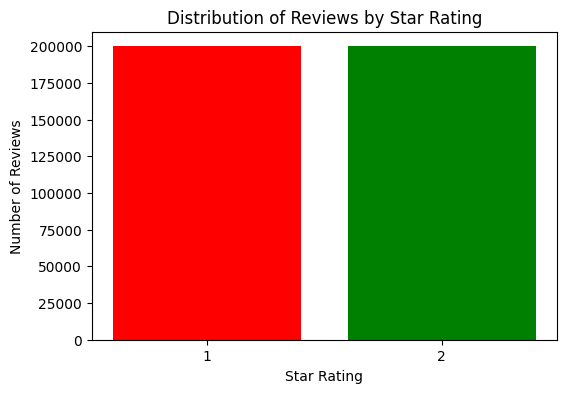

In [ ]:
# 1 — Distribution of reviews across star ratings
rating_data = (
    df.groupBy("label")
      .count()
      .orderBy("label")
      .toPandas()
)

plt.figure(figsize=(6,4))
plt.bar(rating_data["label"], rating_data["count"], color=["red", "green"])
plt.xticks(rating_data["label"])
plt.title("Distribution of Reviews by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()

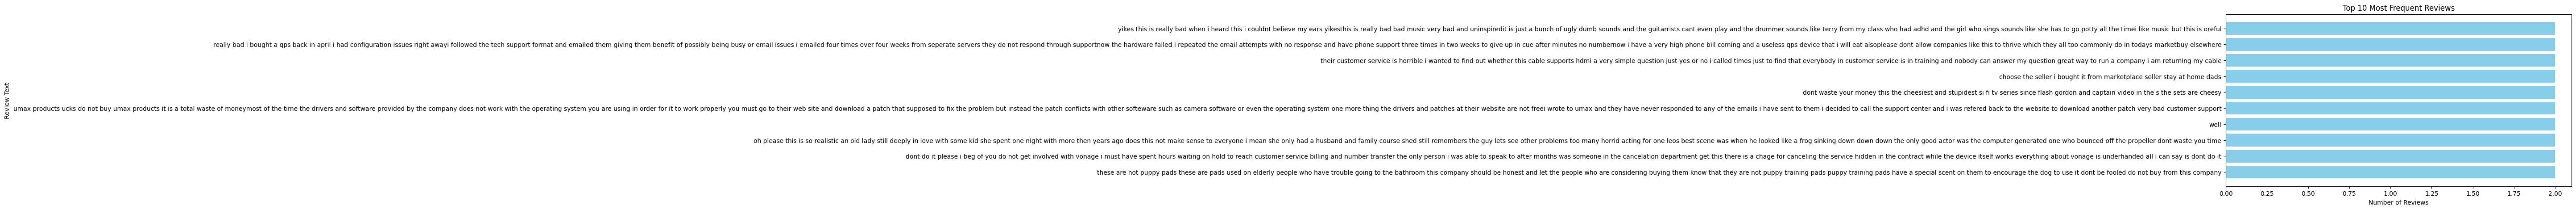

In [ ]:
# 2 — Top 10 most frequent reviews
top_reviews = (
    df.groupBy("clean_review")
      .count()
      .orderBy("count", ascending=False)
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(10,5))
plt.barh(top_reviews["clean_review"], top_reviews["count"], color="skyblue")
plt.gca().invert_yaxis()  # So highest appears at top
plt.title("Top 10 Most Frequent Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Review Text")
plt.show()

## Discussion Questions
Why is Spark better than Pandas for large datasets? Hint: Distributed processing vs single machine memory limits

How does Spark SQL make querying easier?

Where would a Spark cluster provide cost advantages for a company like Netflix?

1. Why is Spark better than Pandas for large datasets?

Scalability → Pandas loads all data into memory on a single machine, which becomes a bottleneck when datasets exceed RAM capacity. Spark processes data in a distributed manner across multiple nodes, allowing it to handle terabytes or petabytes without crashing.

Parallel Processing → Spark can split computations into smaller tasks and execute them in parallel, drastically reducing execution time. Pandas is single-node and limited in parallelism.

Fault Tolerance → Spark automatically recovers from worker node failures by recomputing only lost partitions. Pandas has no such mechanism — if your machine dies, so does your process.

2. How does Spark SQL make querying easier?

SQL Familiarity → Anyone who knows SQL can query big data without learning the full Spark API.

Seamless Integration → You can switch between SQL syntax and DataFrame API (method chaining) depending on the task.

Optimization → Spark SQL uses the Catalyst optimizer, which automatically optimizes queries for performance without user intervention.

Readable Code → Complex joins, aggregations, and filters are often easier to express and maintain in SQL compared to chained DataFrame operations.

3. Where would a Spark cluster provide cost advantages for a company like Netflix?

Elastic Scaling → Netflix can spin up additional Spark cluster nodes only when demand spikes (e.g., during global releases) and scale down afterward — paying only for what they use.

Batch Processing at Scale → Recommendation algorithms, content analytics, and viewing pattern analysis involve processing massive logs — Spark clusters can run these jobs faster, reducing compute time and cloud costs.

Avoiding Over-Provisioning → Instead of buying and maintaining large on-premise servers for peak demand, Netflix can run Spark in a cloud-based, pay-as-you-go environment.